# Задание 2

Имеются результаты A/B теста, в котором двум группам пользователей предлагались различные наборы акционных предложений. Известно, что ARPU в тестовой группе выше на 5%, чем в контрольной. При этом в контрольной группе 1928 игроков из 202103 оказались платящими, а в тестовой – 1805 из 202667.
<br>
Какой набор предложений можно считать лучшим? Какие метрики стоит проанализировать для принятия правильного решения и как?

In [1]:
# Импортируем библиотеки
import numpy as np
import pandas as pd
import scipy
from scipy.stats import shapiro
from scipy.stats import mannwhitneyu
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

plt.style.use('ggplot')                      
plt.rcParams['figure.figsize'] = (15, 10)

In [2]:
# Считаем данные
data = pd.read_csv('https://stepik.org/media/attachments/lesson/409318/problem2.csv', sep=';')
data.head()

,user_id,revenue,testgroup
0,1,0,b
1,2,0,a
2,3,0,a
3,4,0,b
4,5,0,b


Верхнеуровне изучим состав датасета

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404770 entries, 0 to 404769
Data columns (total 3 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   user_id    404770 non-null  int64 
 1   revenue    404770 non-null  int64 
 2   testgroup  404770 non-null  object
dtypes: int64(2), object(1)
memory usage: 9.3+ MB


In [4]:
data.describe()

,user_id,revenue
count,404770.000000,404770.000000
mean,202385.500000,26.083435
std,116847.178567,681.652928
min,1.000000,0.000000
25%,101193.250000,0.000000
50%,202385.500000,0.000000
75%,303577.750000,0.000000
max,404770.000000,37433.000000


In [5]:
data.user_id.duplicated().sum() 

0

## Первый блок (смотрим ARPU)

Разобъем на контрольную и тестовую группы

In [6]:
control = data.query('testgroup == "a" & revenue != 0')['revenue']
test = data.query('testgroup == "b" & revenue != 0')['revenue']

In [7]:
control = control.to_frame()
test = test.to_frame()

In [8]:
control.describe()

,revenue
count,1928.000000
mean,2663.998444
std,9049.039763
min,200.000000
25%,257.000000
50%,311.000000
75%,361.000000
max,37433.000000


In [9]:
test.describe()

,revenue
count,1805.000000
mean,3003.658172
std,572.619709
min,2000.000000
25%,2513.000000
50%,3022.000000
75%,3478.000000
max,4000.000000


Визуализируем распределение платящих пользователей по средней выручке - это даст нам некое понимание структуры групп.

/opt/tljh/user/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/tljh/user/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 0, 'Testgroup = B (test)')

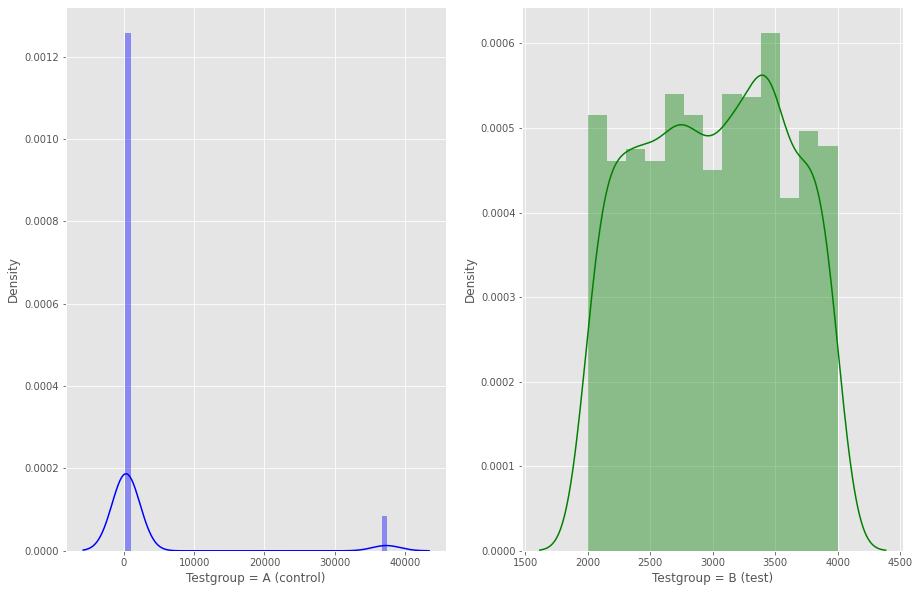

In [69]:
plt.subplot(1, 2, 1)
sns.distplot(control.revenue, color='blue')
plt.xlabel('Testgroup = A (control)')

plt.subplot(1, 2, 2)
sns.distplot(test.revenue, color='green')
plt.xlabel('Testgroup = B (test)')


Исходя из дистограмм, можно сделать следюущий вывод:
<br>
В контрольной группе (Testgroup = A (control)) присутствуют заметные выбросы - пользователи с выручкой,
близкой к 0.

Есть конкретная разница в выручке и выбросах - сделать праное сравнение путем t-теста Стьюдента не получится.
<br>
В таком случае используем критерий Манна-Уитни - он устойчив к выбросам.

In [11]:
statistic, pvalue = scipy.stats.mannwhitneyu(data.query('testgroup == "a"').revenue, data.query('testgroup == "b"').revenue) 
print('statistic = ', statistic)
print('p-value = ', pvalue.round(3))

statistic =  20468349325.0
p-value =  0.031


При p-value = 0.031 можем смело утверждать, что
<br> разница в ARPU в 5% между группами является статистически значимой.
<br> Однако критерий Манна-Уитни не показывает нам, где именно находятся различия - для этого используем Бутстрап и будем сравнивать средние групп.

In [12]:
from tqdm.auto import tqdm

In [13]:
def get_bootstrap(data_column_1, data_column_2, boot_it=1000, statistic=np.mean, bootstrap_conf_level=0.95):
    
    """
        data_column_1: числовые значения первой выборки
        data_column_2: числовые значения второй выборки
        boot_it: количество бутстрэп-подвыборок, по умолчанию 1000
        statistic: интересующая нас статистика, по умолчанию np.mean
        bootstrap_conf_level: уровень значимости, по умолчанию 0.95
    """
    # извлекаем подвыборки
    boot_len = max(len(data_column_1), len(data_column_2))
    boot_data = []
    for i in tqdm(range(boot_it)):
        samples_1 = data_column_1.sample(boot_len, replace = True).values
        
        samples_2 = data_column_2.sample(boot_len, replace = True).values
        
        # применяем статистику (np.mean по умолчанию)
        boot_data.append(statistic(samples_1-samples_2))
        
    # формируем новый датасет из подвыборок        
    pd_boot_data = pd.DataFrame(boot_data)
    
    # рассчитываем доверительный интервал лдя среднего        
    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    ci = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = scipy.stats.norm.cdf(
        x = 0, 
        loc = np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_2 = scipy.stats.norm.cdf(
        x = 0, 
        loc = -np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
        
    # Визуализация
    plt.hist(pd_boot_data[0], bins = 50)
    
    plt.style.use('ggplot')
    plt.vlines(ci,ymin=0,ymax=50,linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()
       
    return {"boot_data": boot_data, 
            "ci": ci, 
            "p_value": p_value}

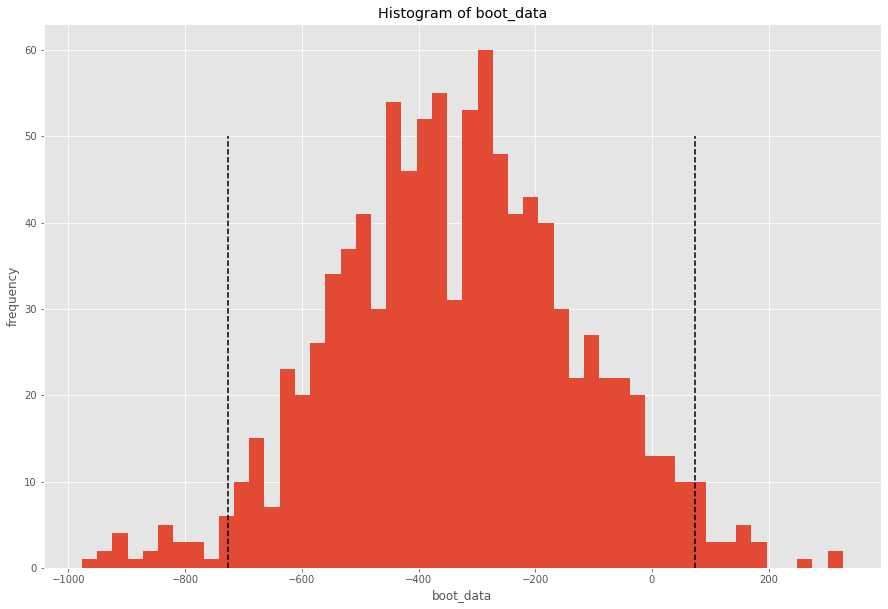

In [14]:
booted_data = get_bootstrap(data.query('testgroup == "a" and revenue != 0').revenue,
                            data.query('testgroup == "b" and revenue != 0').revenue,
                            boot_it=1000)

Так выглядит выборка из разностей средних при использовании 1000 выборок методом Бутстрапа

Найдем p-value

In [15]:
booted_data["p_value"].round(3)

0.108

Посмотрим на полученный доверительный интервал

In [16]:
booted_data["ci"]

,0
0.025,-726.413849
0.975,73.750156


Поскольку p-value > 0.05 и 0 попадает в доверительный интервал это означает, что
<br> значимых статистических различий нет
<br>
Уберем выбросы из контрольной группы (testgroup-A) и запустим Бутстрап снова

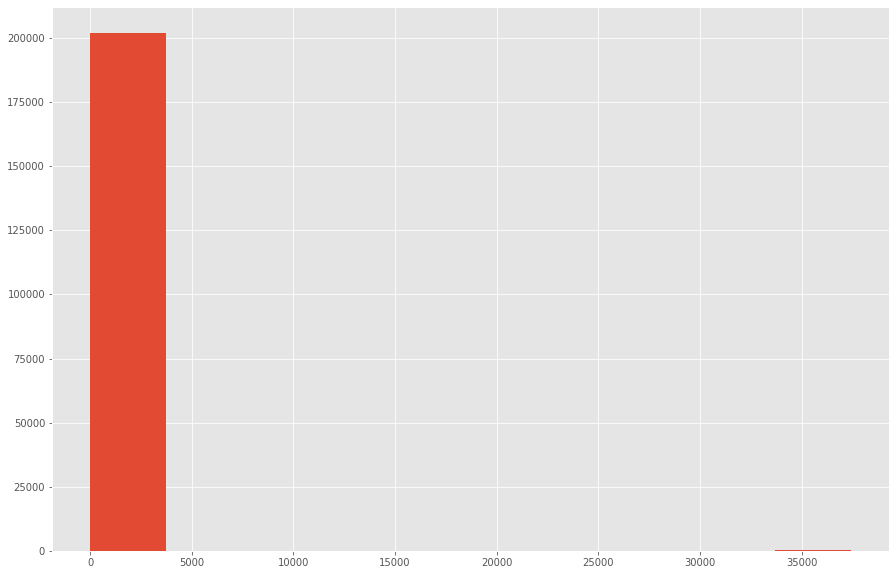

In [27]:
data.query('testgroup == "a"').revenue.hist()

Существуют выбросы, находящиеся за порогом в 30000. Отсеим их

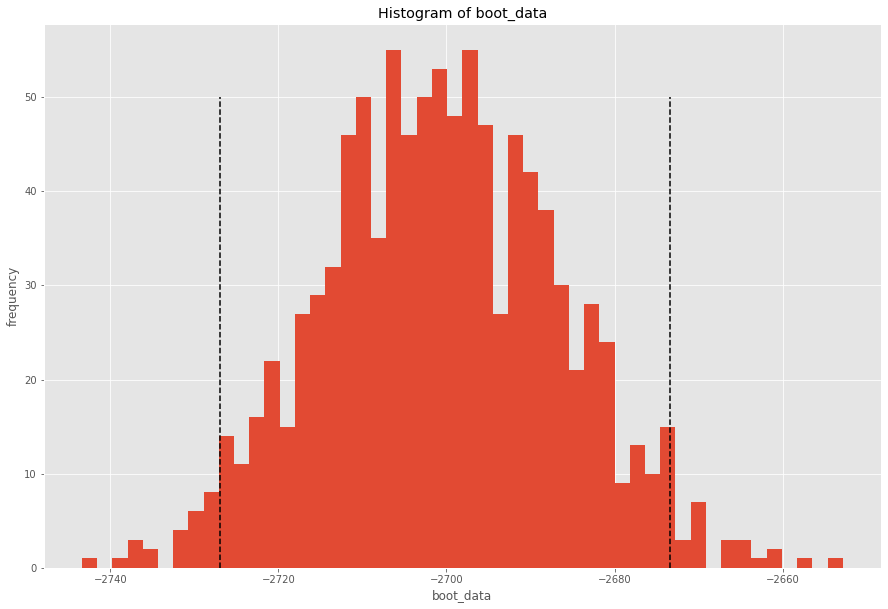

In [28]:
booted_data = get_bootstrap(data.query('testgroup == "a" and 0 != revenue < 30000').revenue,
                            data.query('testgroup == "b" and revenue != 0').revenue)

In [29]:
booted_data["p_value"].round(3)

0.0

In [30]:
booted_data["ci"]

,0
0.025,-2726.940014
0.975,-2673.410000


Теперь, убрав из контрольной группы значения-выбросы, мы получаем значимое значение p-value
<br>
Значит, существует значимая разница в средних Контрольной и Тестовой групп (без учета выбросов!)

## Второй блок (смотрим разницу платящих игроков по группам)

В контрольной группе 1928 игроков из 202103 оказались платящими
<br>
В тестовой группе уже 1805 игроков из 202667 являются платящими

Попробуем понять, если ли значимая разница в том, что в тестовой группе оказалось меньше платящих игроков,
<br>нежели в контрольной

In [32]:
control_all = data.query('testgroup == "a"').shape[0] # общее кол-во игроков в контрольной группе
control_all

202103

In [33]:
test_all = data.query('testgroup == "b"').shape[0] # общее кол-во игроков в тестовой группе
test_all

202667

In [35]:
control_pay_users = data.query('testgroup == "a" and revenue != 0').shape[0] # кол-во платящих игроков в контрольной группе
control_pay_users

1928

In [36]:
test_pay_users = data.query('testgroup == "b" and revenue != 0').shape[0] # кол-во платящих игроков в контрольной группе
test_pay_users

1805

Для проверки значимости различия в кол-ве платящих игроков по группам нам поможет хи-квадрат Пирсона

In [39]:
stat, p, dof, expected = scipy.stats.chi2_contingency([[control_pay_users, test_pay_users], [control_all, test_all]]) 

In [43]:
p.round(3)

0.038

In [45]:
prob = 0.95
critical = scipy.stats.chi2.ppf(prob, dof)
if abs(stat) >= critical:
    print('Отклоняем H0')
else:
    print('Не отклоняем H0')

Отклоняем H0


Наше p-value < 0.05 => мы отклоняем H0 о случайном равенстве кол-ва платящих игроков в разных группах. 
<br> Но опять же, здесь мы проводили сравнения С УЧЕТОМ выбросов в контрольной группе.
<br> Попробуем провести тест Пирсона еще раз, НО БЕЗ УЧЕТА выбросов в контрольной группе.

In [46]:
control_all # общее кол-во игроков в контрольной группе

202103

In [47]:
test_all # общее кол-во игроков в тестовой группе

202667

In [61]:
control_pay_users_without_outliers = data.query('testgroup == "a" and 0 != revenue < 30000').shape[0]
control_pay_users_without_outliers

1805

In [62]:
test_pay_users = data.query('testgroup == "b" and revenue != 0').shape[0]
test_pay_users

1805

In [63]:
stat2, p2, dof2, expected2 = scipy.stats.chi2_contingency([[control_pay_users_without_outliers, test_pay_users], [control_all, test_all]]) 

In [64]:
p2, dof2

(0.9468757370621719, 1)

In [65]:
prob = 0.95
critical = scipy.stats.chi2.ppf(prob, dof2)
if abs(stat2) >= critical:
    print('Отклоняем H0')
else:
    print('Не отклоняем H0')

Не отклоняем H0


P-value > 0.05 => мы не может отклонить H0 - статистически значимых различий нет (можно заметить по графику ниже)
<br> Таким образом, исходя из двух проверок хи-квадратом Пирсона, можем сделать вывод, что выбросы значительно влияют на распределение среднего значения

/opt/tljh/user/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/tljh/user/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 0, 'Testgroup = B (test)')

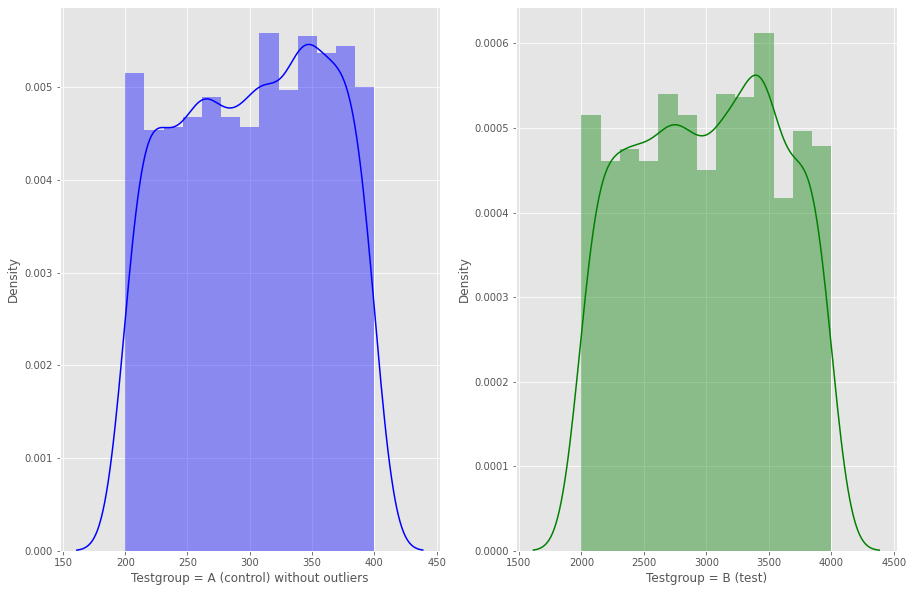

In [67]:
plt.subplot(1, 2, 1)
sns.distplot(data.query('testgroup == "a" and 0 != revenue < 30000').revenue, color='blue')
plt.xlabel('Testgroup = A (control) without outliers')

plt.subplot(1, 2, 2)
sns.distplot(data.query('testgroup == "b" and revenue != 0').revenue, color='green')
plt.xlabel('Testgroup = B (test)')

# Выводы 

<ol>
    <li> Выводы зависят от нашей методики тестирования - учитываем мы выбросы или нет </li>
    <li> Выручка отличается в десяток раз по группам - ошбика в сплитовании или же другая проблема (скорее всего) </li>
    <li> Если убрать выбросы, то по тесту Манна-Уитни и бутстрапу получается, что ARPU в тестовой выросло статистически значимо => Пускаем тест в продакт </li>
</ol>